# Diamond Price Prediction (Regression)

Dataset Link: https://www.kaggle.com/datasets/shivam2503/diamonds/data  

Algorithms: Linear Regression, Random Forest

Load Dataset

In [192]:
import pandas as pd                                                             # for data analysis, cleaning and exploration
import numpy as np                                                              # for numerical operations                        
import matplotlib.pyplot as plt                                                 # for data visualization 
import seaborn as sns                                                           # for statiscal visualization
from sklearn.feature_selection import mutual_info_regression                    # for feature selection
from sklearn.model_selection import train_test_split                            # split train and test data
from sklearn.preprocessing import StandardScaler                                # normalize data
from sklearn.linear_model import LinearRegression                               # linear regression model
from sklearn.model_selection import GridSearchCV                                # hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error   # model evaluation
from sklearn.ensemble import RandomForestRegressor                              # random forest model

In [193]:
# Load the data
data = pd.read_csv('diamonds.csv')
data

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


**Dataset Description:** 

**price:** price in US dollars (\$326--\$18,823)

**carat:** weight of the diamond (0.2--5.01)

**cut:** quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**color:** diamond colour, from J (worst) to D (best)

**clarity:** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

**x:** length in mm (0--10.74)

**y:** width in mm (0--58.9)

**z:** depth in mm (0--31.8)

**depth:** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**table:** width of top of diamond relative to widest point (43--95)

In [194]:
# remove the first column
data = data.drop(data.columns[0], axis=1)

In [195]:
# check for missing values
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

### Exploratory Data Analysis (EDA)

In [196]:
# summary of the data
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


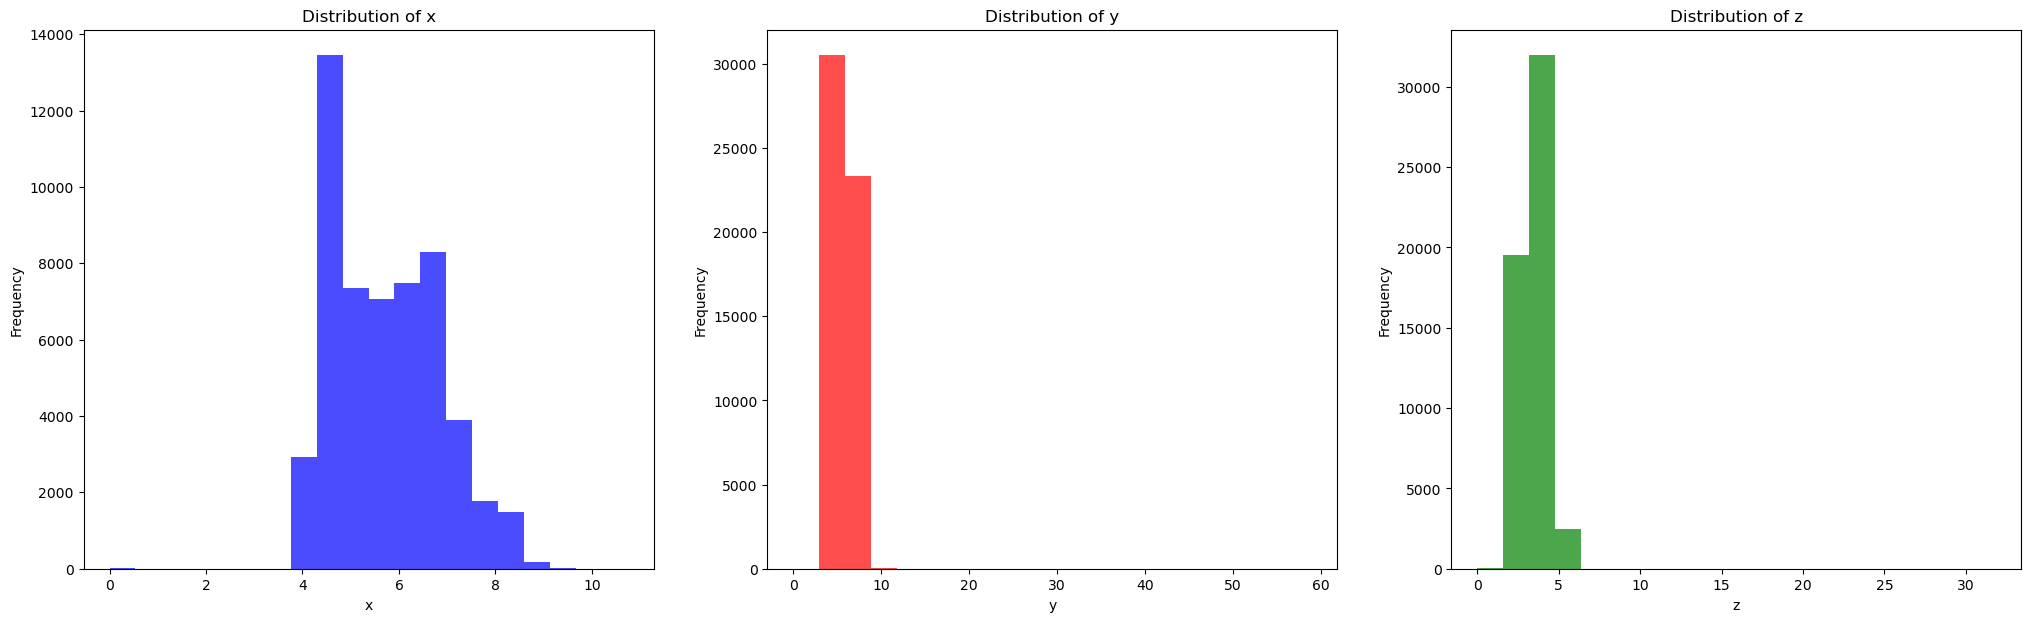

In [197]:
# Distribution of x, y, z
plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
plt.hist(data['x'], bins=20, color='blue', alpha=0.7)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Distribution of x')

plt.subplot(1, 3, 2)
plt.hist(data['y'], bins=20, color='red', alpha=0.7)
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('Distribution of y')

plt.subplot(1, 3, 3)
plt.hist(data['z'], bins=20, color='green', alpha=0.7)
plt.xlabel('z')
plt.ylabel('Frequency')
plt.title('Distribution of z')
plt.show()


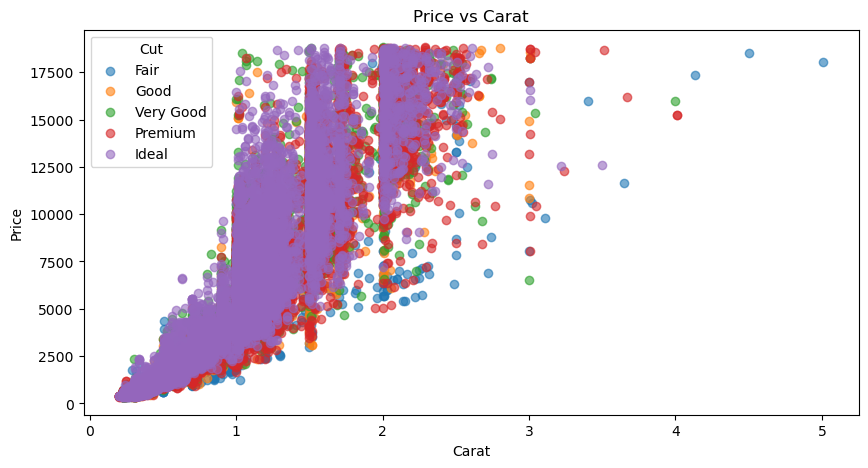

In [198]:
# find relationship between price and carat and cuts as legend 
plt.figure(figsize=(10, 5))
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
for cut in cut_order:
    subset = data[data['cut'] == cut]
    plt.scatter(subset['carat'], subset['price'], label=cut, alpha=0.6)

plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Price vs Carat')
plt.legend(title="Cut")
plt.show()

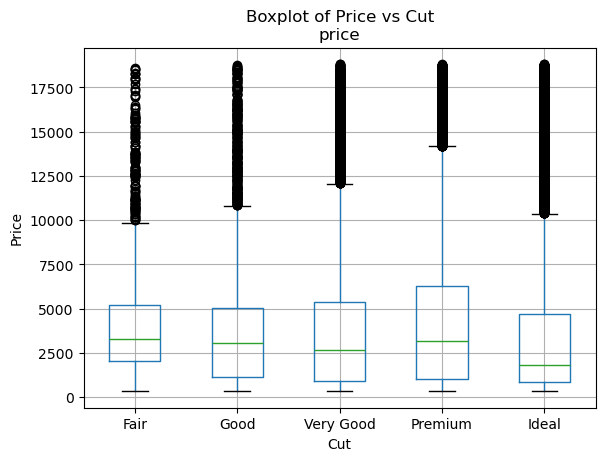

In [199]:
# Find distribution between price and cuts sort by fair, good, very good, premium, ideal
data['cut'] = pd.Categorical(data['cut'], categories=cut_order, ordered=True)
data.boxplot(column='price', by='cut')
plt.xlabel('Cut')
plt.ylabel('Price')
plt.suptitle('Boxplot of Price vs Cut')
plt.show()


## Correlation Matrix


In [200]:
# turn categorical data into numerical data (one hot encoding)
data = pd.get_dummies(data)
data.head()


,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Very Good,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,False,True,False,...,False,True,False,False,False,True,False,False,False,False


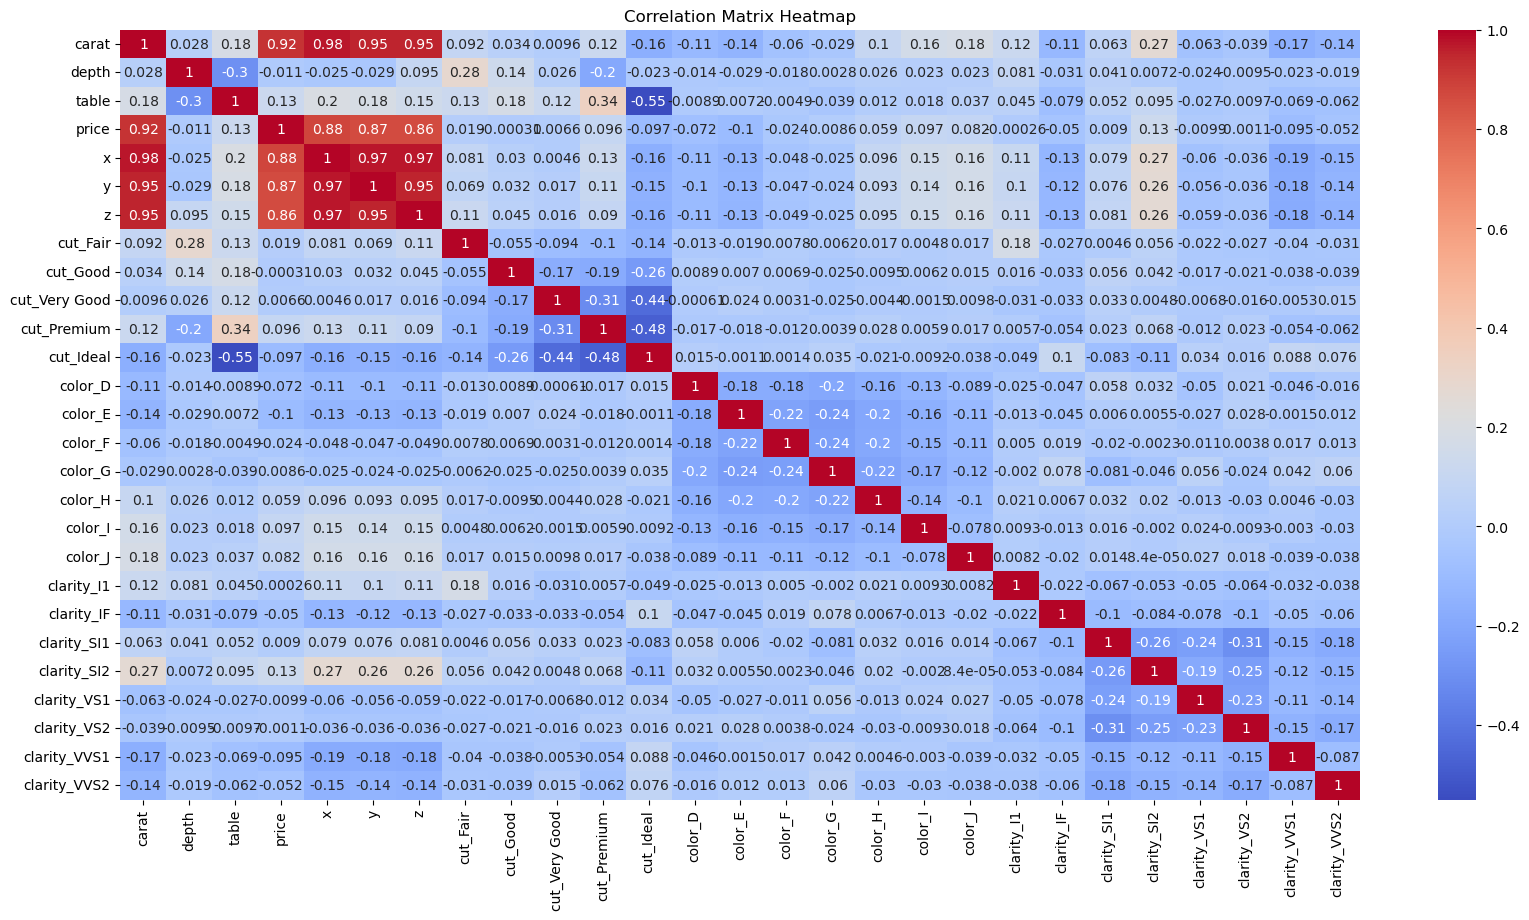

In [201]:
# Correlation matrix heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix above shows that price is highly correlated with carat, x, y and z.

## Feature Importance
Feature selection determines which features have the most influence on helping to determine the target. 

Correlation refers to how close two variables in terms of having a linear relationship with each other.

In [202]:
#split features and target (price)
X = data.drop('price', axis=1) 
y = data['price']

mutual_info = mutual_info_regression(X, y)

# Create a series with the feature names as index
mi_series = pd.Series(mutual_info, index=X.columns)
mi_series.sort_values(ascending=False, inplace=True)
print(mi_series)


carat            1.961665
y                1.492911
x                1.481185
z                1.434277
clarity_SI1      0.097022
clarity_VS2      0.091154
clarity_SI2      0.078619
color_E          0.073137
color_D          0.070643
color_G          0.062837
color_F          0.060841
table            0.056222
clarity_VS1      0.053821
clarity_VVS2     0.052820
clarity_VVS1     0.051424
cut_Ideal        0.048365
color_H          0.047061
cut_Premium      0.042446
clarity_IF       0.037613
depth            0.036072
color_I          0.033885
cut_Very Good    0.030032
color_J          0.022082
cut_Good         0.015703
cut_Fair         0.009007
clarity_I1       0.004956
dtype: float64


# Model Training

## Linear Regression

In [203]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43152, 26), (10788, 26), (43152,), (10788,))

In [204]:
# Linear Regression before scaling
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [205]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1288705.4778516742
Root Mean Squared Error: 1135.2116445190625
R2 Score: 0.9189331350419387
Mean Absolute Error: 737.1513665933269


In [206]:
# normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [207]:
# Linear Regression after scaling
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

In [208]:
# Model Evaluation mse, rmse, r2, mae
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1288705.477851674
Root Mean Squared Error: 1135.2116445190622
R2 Score: 0.9189331350419387
Mean Absolute Error: 737.1513665933271


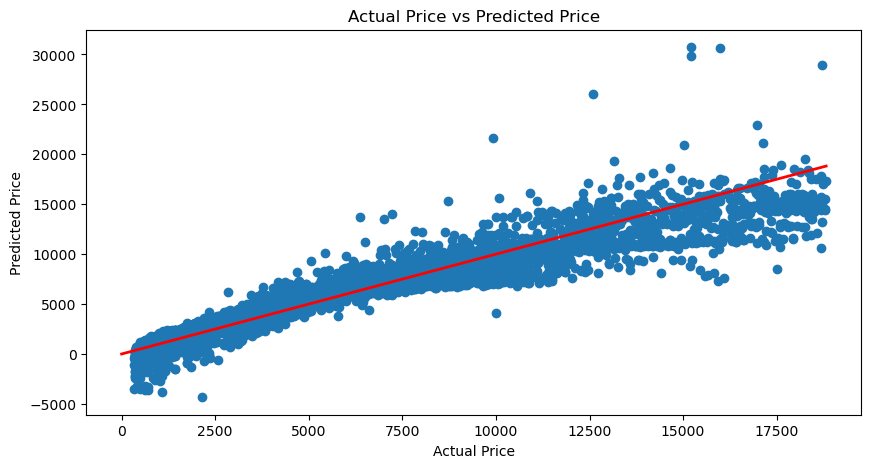

In [209]:
# plot the predicted price vs actual price with regression line
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()


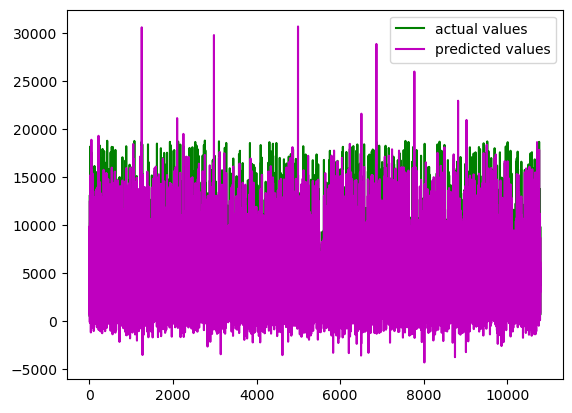

In [210]:
# plot for actual values and predicted values
# acutal values
plt.plot([i for i in range(len(y_test))],np.array(y_test), c='g', label="actual values")

# predicted values
plt.plot([i for i in range(len(y_test))],y_pred, c='m',label="predicted values")
plt.legend()
plt.show()

### Predict Price of diamond using Linear Regression

In [247]:
# given features, predict the price and show actual price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price = model.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price}')

Actual Price: 1238
Predicted Price: -7938.733896008933


### Do L2 Regularization

In [212]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Define the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100]}

# L2 Regularization
ridge = Ridge()
# Perform Grid Search
grid_search_l2 = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_l2.fit(X_train, y_train)

# Get the best parameters and model
best_params_l2 = grid_search_l2.best_params_
best_model_l2 = grid_search_l2.best_estimator_


In [213]:
best_model_l2.fit(X_train, y_train)

y_pred_l2 = best_model_l2.predict(X_test_scaled)

c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [233]:
# Model Evaluation mse, rmse, r2, mae
mse_l2 = mean_squared_error(y_test, y_pred)
rmse_l2 = np.sqrt(mse_l2)
r2_l2 = r2_score(y_test, y_pred)
mae_l2 = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse_l2}')
print(f'Root Mean Squared Error: {rmse_l2}')
print(f'R2 Score: {r2_l2}')
print(f'Mean Absolute Error: {mae_l2}')

Mean Squared Error: 1288705.477851674
Root Mean Squared Error: 1135.2116445190622
R2 Score: 0.9189331350419387
Mean Absolute Error: 737.1513665933271


In [244]:
# predict price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_l2 = best_model_l2.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_l2}')

Actual Price: 1238
Predicted Price: 1947.1739070880103


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


### Do L1 Regularization

In [216]:
# DEfine the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100]}

# L1 Regularization
lasso = Lasso()
# Perform Grid Search
grid_search_l1 = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_l1.fit(X_train, y_train)

# Get the best parameters and model
best_params_l1 = grid_search_l1.best_params_
best_model_l1 = grid_search_l1.best_estimator_

c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.979e+07, tolerance: 5.552e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.737e+07, tolerance: 5.478e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.781e+07, tolerance: 5.4

In [217]:
best_model_l1.fit(X_train, y_train)

y_pred_l1 = best_model_l1.predict(X_test_scaled)

c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.515e+07, tolerance: 6.870e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


In [234]:
# Model Evaluation mse, rmse, r2, mae
mse_l1 = mean_squared_error(y_test, y_pred)
rmse_l1 = np.sqrt(mse_l1)
r2_l1 = r2_score(y_test, y_pred)
mae_l1 = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse_l1}')
print(f'Root Mean Squared Error: {rmse_l1}')
print(f'R2 Score: {r2_l1}')
print(f'Mean Absolute Error: {mae_l1}')

Mean Squared Error: 1288705.477851674
Root Mean Squared Error: 1135.2116445190622
R2 Score: 0.9189331350419387
Mean Absolute Error: 737.1513665933271


In [245]:
# Predict price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_l1 = best_model_l1.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_l1}')

Actual Price: 1238
Predicted Price: 1945.9599446886086


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


### Do L1+L2 Regularization

In [220]:
# Define the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
np.space(-6, 6, 13)
# Elastic Net Regularization
elastic_net = ElasticNet()
# Perform Grid Search
grid_search_en = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_en.fit(X_train, y_train)

# Get the best parameters and model
best_params_en = grid_search_en.best_params_
best_model_en = grid_search_en.best_estimator_

In [221]:
best_model_en.fit(X_train, y_train)

y_pred_en = best_model_en.predict(X_test_scaled)

c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


In [236]:
# Model Evaluation mse, rmse, r2, mae
mse_l1l2 = mean_squared_error(y_test, y_pred)
rmse_l1l2 = np.sqrt(mse_l1l2)
r2_l1l2 = r2_score(y_test, y_pred)
mae_l1l2 = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse_l1l2}')
print(f'Root Mean Squared Error: {rmse_l1l2}')
print(f'R2 Score: {r2_l1l2}')
print(f'Mean Absolute Error: {mae_l1l2}')

Mean Squared Error: 1288705.477851674
Root Mean Squared Error: 1135.2116445190622
R2 Score: 0.9189331350419387
Mean Absolute Error: 737.1513665933271


In [246]:
# Predict price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_l1l2 = best_model_en.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_l1l2}')

Actual Price: 1238
Predicted Price: 1880.8227222757241


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


## Random Forest

In [224]:
# model with 1000 trees
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# train model on training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [225]:
# predict price on test data
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation mse, rmse, r2, mae
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f'Mean Squared Error: {mse_rf}')
print(f'Root Mean Squared Error: {rmse_rf}')
print(f'R2 Score: {r2_rf}')
print(f'Mean Absolute Error: {mae_rf}')


Mean Squared Error: 300642.9310074715
Root Mean Squared Error: 548.3091564140358
R2 Score: 0.9810878588572404
Mean Absolute Error: 269.050603440588


In [226]:
# Calculate accuracy
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
accuracy_rf = 100 - mape_rf
print(f'Accuracy: {accuracy_rf}')

Accuracy: 93.54207416508297


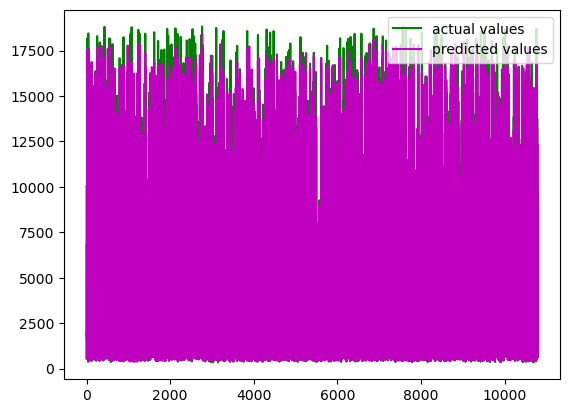

In [227]:
# acutal values
plt.plot([i for i in range(len(y_test))],np.array(y_test), c='g', label="actual values")

# predicted values
plt.plot([i for i in range(len(y_test))],y_pred_rf, c='m',label="predicted values")
plt.legend()
plt.show()

## Comparison between Linear Regression and Random Forest


In [237]:
# show a table of mae, mse, rmse, r2 of linear regression and random forest
results = pd.DataFrame({
    'Linear Regression': [mae, mse, rmse, r2],
    'Ridge Regression': [mae_l2, mse_l2, rmse_l2, r2_l2],
    'Lasso Regression': [mae_l1, mse_l1, rmse_l1, r2_l1],
    'Elastic Net': [mae_l1l2, mse_l1l2, rmse_l1l2, r2_l1l2],
    'Random Forest': [mae_rf, mse_rf, rmse_rf, r2_rf]
}, index=['MAE', 'MSE', 'RMSE', 'R2'])
results

,Linear Regression,Ridge Regression,Lasso Regression,Elastic Net,Random Forest
MAE,7.371514e+02,7.371514e+02,7.371514e+02,7.371514e+02,269.050603
MSE,1.288705e+06,1.288705e+06,1.288705e+06,1.288705e+06,300642.931007
RMSE,1.135212e+03,1.135212e+03,1.135212e+03,1.135212e+03,548.309156
R2,9.189331e-01,9.189331e-01,9.189331e-01,9.189331e-01,0.981088


### Predict Price of diamond using Random Forest

In [242]:
# Given features, predict the price and show actual price also
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_rf = rf_model.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_rf}')

Actual Price: 1238
Predicted Price: 1217.358


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Comparison between Actual and Predicted Price

In [248]:
# show the comaprison between the actual price and predicted price of two models in a table
comparison = pd.DataFrame({
    'Actual Price': actual_price,
    'Linear Regression': predicted_price,
    'LinearRegression L2': predicted_price_l2,
    'LinearRegression L1': predicted_price_l1,
    'LinearRegression L1L2)': predicted_price_l1l2,
    'Random Forest (Prediction)': predicted_price_rf
}, index=['Diamond Price'])

comparison

,Actual Price,Linear Regression,LinearRegression L2,LinearRegression L1,LinearRegression L1L2),Random Forest (Prediction)
Diamond Price,1238,-7938.733896,1947.173907,1945.959945,1880.822722,1217.358
